# Определение стоимости автомобилей

Цель: нужно построить модель для определения стоимости автомобиля 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Решаем задачу регрессии

# Содержание

1. Подготовка данных

   - 1.1 Общее изучение данных
   - 1.2 Работа с проупсками и дубликатами
   - 1.3 Деление на выборки, кодировка и масштабирование


2. Обучение моделей
3. Анализ моделей

## Подготовка данных

### Общее изучение данных

Импортируем необходимые библиотеки, читаем данные из файла и изучаем датасет

In [3]:
!pip install scikit-learn==1.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.8 MB/s eta 0:00:00


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

In [6]:
data = pd.read_csv('autos.csv')
data_full = data.copy()
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Удалим неиформативные столбцы

In [8]:
data = data.drop(columns=['DateCrawled', 'RegistrationMonth', 'PostalCode', 'LastSeen'], axis=1)

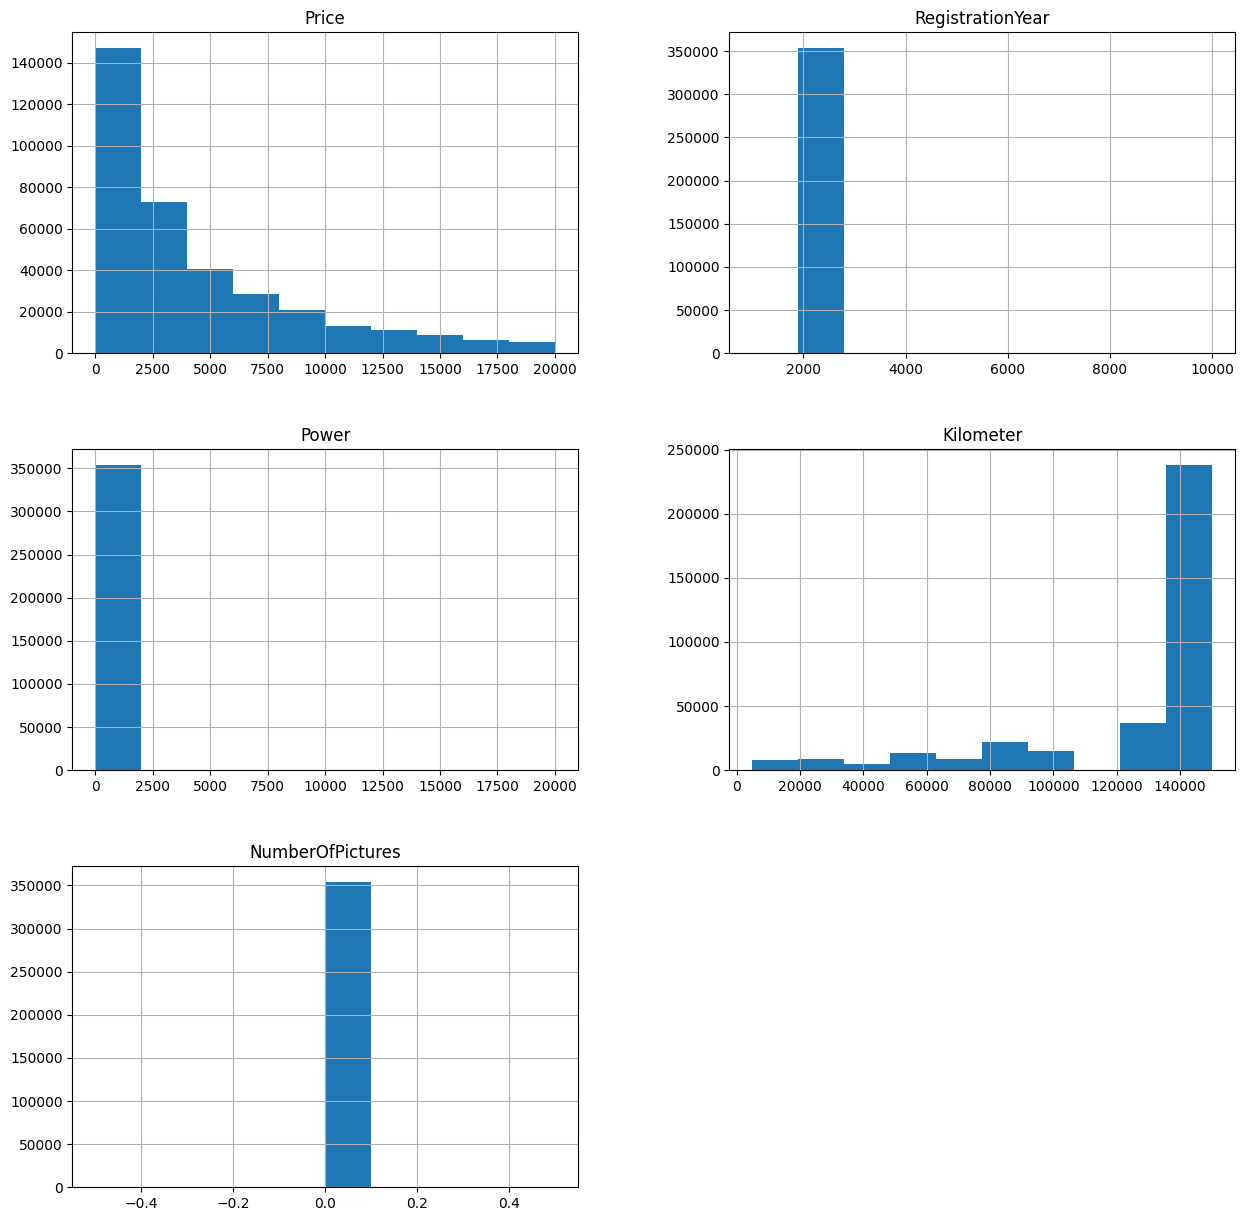

In [9]:
data.hist(figsize=(15, 15));

In [10]:
data['NumberOfPictures'].value_counts()

0    354369
Name: NumberOfPictures, dtype: int64

Столбец с количеством фотографий содержит одни нули, поэтому удалим его

In [11]:
data = data.drop('NumberOfPictures', axis=1)

Посмотрим, сколько нулей в столбце с ценой

In [12]:
data.loc[data['Price'] == 0, 'Price'].count()

10772

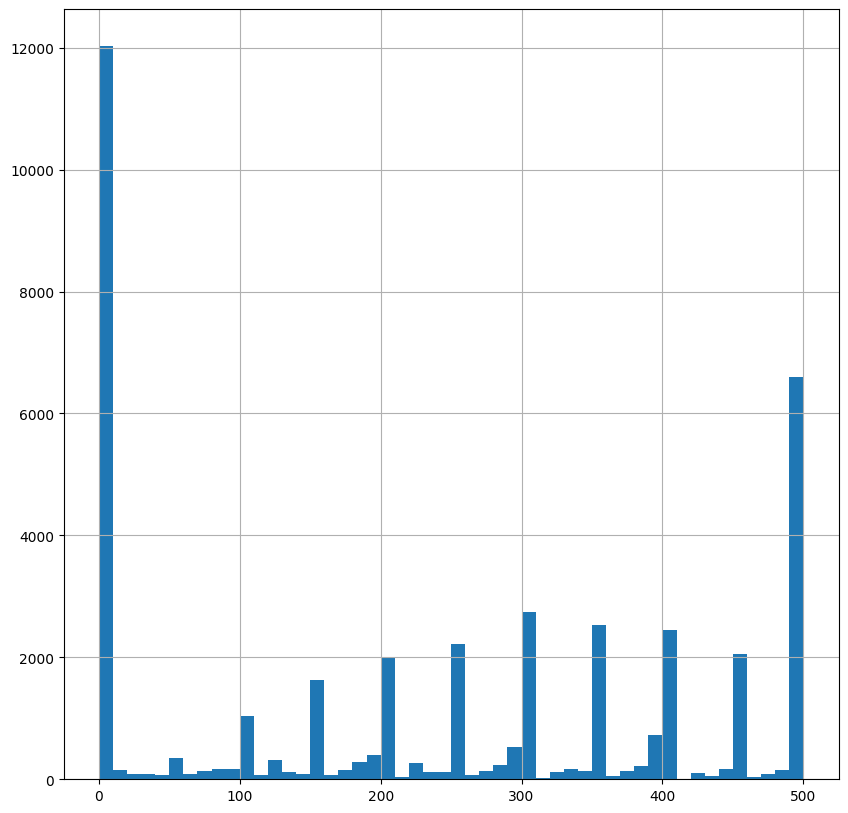

In [13]:
data['Price'].hist(bins=50, figsize=(10, 10), range=(0, 500));

### Работа с пропусками и дубликатами

In [14]:
data['Price'].describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

Так как нулевых значений не так много, удалим их, так как пытаться восстанавливать целевой признак нежелательно

In [15]:
data_null_price = data.loc[data['Price'] == 0]
data = data.loc[data['Price'] != 0]
data['Price'].describe()

count    343597.000000
mean       4555.121974
std        4515.058553
min           1.000000
25%        1200.000000
50%        2890.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

Изучим столбец мощность

In [16]:
data['Power'].value_counts()

0       36360
75      23319
60      15465
150     14170
101     12960
        ...  
519         1
2461        1
6006        1
5815        1
1241        1
Name: Power, Length: 701, dtype: int64

In [17]:
data['Power'].describe()

count    343597.000000
mean        111.000192
std         188.177974
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

Также заменим нулевые значения, которых не может быть, на медианное значение по моделям автомобилей. Отсечём выбросы. Потенциально самый мощный автомобиль в мире имеет 4000 л.с., поэтому основываемся на реалистичности

In [18]:
data['Power'] = data['Power'].fillna(data.groupby(by=['Model'])['Power'].transform('median'))
data = data.query('Power <= 4000')
data['Power'].value_counts()

0       36360
75      23319
60      15465
150     14170
101     12960
        ...  
700         1
2331        1
2789        1
519         1
1241        1
Name: Power, Length: 626, dtype: int64

Заменим неявный дубликат в столбце модели

In [19]:
data['Model'] = data['Model'].replace('rangerover', 'range_rover')

Выделим из данных теоретически возможный год регистрации авто

In [20]:
data = data.query('1885 <= RegistrationYear <= 2016')
data['RegistrationYear'].value_counts()

2000    23068
1999    21990
2005    21521
2006    19674
2001    19645
        ...  
1949        1
1931        1
1925        1
1927        1
1946        1
Name: RegistrationYear, Length: 92, dtype: int64

Добавим столбец с возрастом автомобиля, рассчитав его как разность между годом регистрации и датой создания анкеты

In [21]:
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%Y.%m.%d %H:%M:%S')
data['Age'] = pd.DatetimeIndex(data['DateCreated']).year - data['RegistrationYear']
data.head()

<ipython-input-21-68edd2b4ab15>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%Y.%m.%d %H:%M:%S')


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,DateCreated,Age
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,2016-03-24,23
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,2016-03-24,5
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,2016-03-14,12
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,2016-03-17,15
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,2016-03-31,8


Удалим теперь ненужные столбцы

In [22]:
data = data.drop(columns=['RegistrationYear', 'DateCreated'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329690 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Price        329690 non-null  int64 
 1   VehicleType  309758 non-null  object
 2   Gearbox      314091 non-null  object
 3   Power        329690 non-null  int64 
 4   Model        314060 non-null  object
 5   Kilometer    329690 non-null  int64 
 6   FuelType     305528 non-null  object
 7   Brand        329690 non-null  object
 8   Repaired     269835 non-null  object
 9   Age          329690 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 27.7+ MB


Заполним пропуски в колонках категориальных признаков

In [23]:
data = data.fillna('unknown')

Посмотрим, сколько строк мы удалили

In [24]:
data_full.shape[0] - data.shape[0]

24679

В процентах

In [25]:
1 - (data.shape[0] / data_full.shape[0])

0.06964209623302264

In [26]:
data.head(10)

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,Age
0,480,unknown,manual,0,golf,150000,petrol,volkswagen,unknown,23
1,18300,coupe,manual,190,unknown,125000,gasoline,audi,yes,5
2,9800,suv,auto,163,grand,125000,gasoline,jeep,unknown,12
3,1500,small,manual,75,golf,150000,petrol,volkswagen,no,15
4,3600,small,manual,69,fabia,90000,gasoline,skoda,no,8
5,650,sedan,manual,102,3er,150000,petrol,bmw,yes,21
6,2200,convertible,manual,109,2_reihe,150000,petrol,peugeot,no,12
8,14500,bus,manual,125,c_max,30000,petrol,ford,unknown,2
9,999,small,manual,101,golf,150000,unknown,volkswagen,unknown,18
10,2000,sedan,manual,105,3_reihe,150000,petrol,mazda,no,12


### Деление на выборки, кодировка и масштабирование 

Выделим признаки и целевой признак, разделим на обучающую и тестовую выборки

In [27]:
features = data.drop('Price', axis=1)
target = data['Price']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

In [28]:
features_train.shape

(247267, 9)

In [29]:
features_test.shape

(82423, 9)

Закодируем категориальные признаки в численные с помощью порядкового кодирования

In [30]:
oe_features = features_train.select_dtypes(include='object').columns.to_list()

encoder = OrdinalEncoder()
encoder.fit(features_train[oe_features])

features_train[
    encoder.get_feature_names_out()
] = encoder.transform(features_train[oe_features])

features_test[
    encoder.get_feature_names_out()
] = encoder.transform(features_test[oe_features])

Масштабируем наш датасет, чтобы нивелировать разность в размерах чисел в столбцах

In [31]:
pd.options.mode.chained_assignment = None

scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

Вывод: в датасете достаточно много пропусков, которые частично пришлось заполнить заглушками. В идеальном варианте для точного предсказания модели необходимо вычистить все неполные данные, так как восстановить их на 100% верно не представляется возможным, а искажения ведут к неточным предсказаниям. В нашем случае мы могли бы потерять много данных, убрав все пропуски. Поэтому, несмотря на небольшое снижения качества моделей, данные всё же были частично восстановлены

## Обучение моделей

В этом разделе с помощью RandomizedSearchCV подберём лучшие гиперпараметры 4 моделям, 2 из которых градиентный бустинг, а 2 нет

Обучим модель решающего дерева

In [32]:
%%time

params_dt = {'max_depth': range(15, 26),
             'min_samples_split': range(2, 10),
             'min_samples_leaf': range(1, 10)}
cv_dt = RandomizedSearchCV(DecisionTreeRegressor(random_state=12345), params_dt, scoring='neg_root_mean_squared_error')

dt_model = cv_dt.fit(features_train, target_train)
print('Лучшие параметры решающего дерева:', dt_model.best_params_)
print('Лучший RMSE:', abs(dt_model.best_score_))

Лучшие параметры решающего дерева: {'min_samples_split': 6, 'min_samples_leaf': 6, 'max_depth': 18}
Лучший RMSE: 1833.1396374581395
CPU times: user 42.5 s, sys: 71.6 ms, total: 42.5 s
Wall time: 48.2 s


Обучим модель случайного леса

In [33]:
%%time

params_rf = {'max_depth': range(6, 16),
             'n_estimators': range(50, 81, 10),
             'min_samples_split': range(2, 10)}
cv_rf = RandomizedSearchCV(RandomForestRegressor(random_state=12345), params_rf, scoring='neg_root_mean_squared_error')

rf_model = cv_rf.fit(features_train, target_train)
print('Лучшие параметры рандомного леса:', rf_model.best_params_)
print('Лучший RMSE:', abs(rf_model.best_score_))

Лучшие параметры рандомного леса: {'n_estimators': 80, 'min_samples_split': 8, 'max_depth': 15}
Лучший RMSE: 1676.737314481507
CPU times: user 21min 38s, sys: 1.53 s, total: 21min 40s
Wall time: 21min 44s


Обучим модель LGBM

In [34]:
%%time

params_lgbm = {'max_depth': range(6, 16),
             'n_estimators': range(10, 31, 10)}
cv_lgbm = RandomizedSearchCV(LGBMRegressor(random_state=12345), params_lgbm, scoring='neg_root_mean_squared_error')

lgbm_model = cv_lgbm.fit(features_train, target_train)
print('Лучшие параметры LGBM:', lgbm_model.best_params_)
print('Лучший RMSE:', abs(lgbm_model.best_score_))

Лучшие параметры LGBM: {'n_estimators': 30, 'max_depth': 14}
Лучший RMSE: 1960.764537024065
CPU times: user 59.2 s, sys: 210 ms, total: 59.4 s
Wall time: 34.3 s


Обучим модель CatBoost

In [35]:
%%time

params_cat = {'max_depth': range(6, 16),
             'n_estimators': range(50, 81, 10)}
cv_cat = RandomizedSearchCV(CatBoostRegressor(random_state=12345, verbose=False), 
                            params_cat, scoring='neg_root_mean_squared_error')

cat_model = cv_cat.fit(features_train, target_train)
print('Лучшие параметры CatBoost:', cat_model.best_params_)
print('Лучший RMSE:', abs(cat_model.best_score_))

Лучшие параметры CatBoost: {'n_estimators': 80, 'max_depth': 14}
Лучший RMSE: 1634.3377246271323
CPU times: user 13min 53s, sys: 3min 32s, total: 17min 26s
Wall time: 11min 23s


Вывод: в этом разделе мы обучили и c помощью RandomizedSearchCV подобрали лучшие гиперпараметры к четырём моделям, две - бустинг, две - не бустинг. Лучший результат по RMSE показала модель CatBoost. Определиться со временем обучения и предсказания мы сможем, проанализировав эту модель на тестовой выборке

## Анализ моделей

Проанализируем время обучения, время предсказания и качество модели CatBoost с лучшими гиперпараметрами

In [40]:
%%timeit

cat_model = CatBoostRegressor(random_state=12345, verbose=False, max_depth=14, n_estimators=80)
cat_model.fit(features_train, target_train)

25 s ± 1.1 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
%%timeit

cat_model.predict(features_test)

53.1 ms ± 975 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [42]:
print('RMSE:', mean_squared_error(target_test, cat_model.predict(features_test), squared=False))

RMSE: 1616.295963163732


Вывод: Несмотря на то, что модель решающего дерева обучается и даёт предсказания быстрее, качество несравнимо лучше у модели CatBoost. Случайный лес по качеству сопоставим с CatBoost, но долго даёт предсказания. LGBM не отличилась ни скоростью, ни качеством

Таким образом, с учётом пожеланий заказчика, лучшая модель для предсказаний стоимости автомобиля - это CatBoost.

Время обучения: 25 s ± 1.1 s

Время предсказания: 53.1 ms ± 975 ms

RMSE на тестовой выборке: 1616.295963163732